In [97]:
import requests                
from bs4 import BeautifulSoup 
import pandas as pd
import re
import csv
import json
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import time


In [2]:
def extract_bv_id(url):
    match = re.search(r'video/(BV\w+)', url)
    if match:
        return match.group(1)  
    return None


In [5]:
def get_bulletcomment(link):
    '''
    given url, get the bullet comment of that video
    '''
    BV = extract_bv_id(link)
    #BV = re.search(r'/video/(BV\w+)/', link).group(1) # for each video it has an unique BV id in its url
    apilink = 'https://api.bilibili.com/x/player/pagelist?bvid=' + BV + '&jsonp=jsonp'

    header = { "User-Agent" : "demo scraper for teaching purposes ys@u.edu" } 
    response = requests.get(apilink, headers = header)
    cid = (response.json())['data'][0]['cid']

    cidlink = 'https://comment.bilibili.com/'+ str(cid) + '.xml'
    #print(cidlink)
    response = requests.get(cidlink, headers = header)
    soup = BeautifulSoup(response.text, "lxml-xml")
    texts = [d.text for d in soup.find_all('d')]
    return texts



data = get_bulletcomment('https://www.bilibili.com/video/BV1wD421W7GP/?spm_id_from=333.1007.tianma.1-3-3.click&vd_source=a676e9574ae10f45ae8a73f5c6c428fd')


https://comment.bilibili.com/1493286480.xml


In [54]:
def get_bulletcomment_score(link):
    '''
    given url, get the bullet comment of that video
    '''
    BV = extract_bv_id(link)
    #BV = re.search(r'/video/(BV\w+)/', link).group(1) # for each video it has an unique BV id in its url
    apilink = 'https://api.bilibili.com/x/player/pagelist?bvid=' + BV + '&jsonp=jsonp'

    header = { "User-Agent" : "demo scraper for teaching purposes ys@u.edu" } 
    response = requests.get(apilink, headers = header)
    cid = (response.json())['data'][0]['cid']

    cidlink = 'https://comment.bilibili.com/'+ str(cid) + '.xml'
    #print(cidlink)
    response = requests.get(cidlink, headers = header)
    soup = BeautifulSoup(response.text, "lxml-xml")
    #texts = [d.text.encode('latin1').decode('utf-8') for d in soup.find_all('d')]

    d_tags = soup.find_all('d')
    output = []
    for tag in d_tags:
    # Split the 'p' attribute by commas and get the last element
        other_info = tag['p'].split(',')
        score = tag['p'].split(',')[-1]
        text = tag.text.encode('latin1').decode('utf-8')
        output.append([text, int(score), other_info])

    return output

using get_bulletcomment_score(url) will give us a list of list containing all the bullet comment of a single video: [[comment, score, other-information], [], []...]

In [ ]:
data=get_bulletcomment_score("https://www.bilibili.com/video/BV1364y1U7Ss/?spm_id_from=333.337.search-card.all.click&vd_source=a676e9574ae10f45ae8a73f5c6c428fd")


In [57]:
print(data[0])

['警惕娱乐圈！', 10, ['235.03900', '5', '25', '16707842', '1620133001', '0', 'b1b6557a', '48753974511665159', '10']]


In [77]:
def get_video_info(link):
    header = { "User-Agent" : "demo scraper for teaching purposes ys@u.edu" } 
    response = requests.get(link, headers = header)

    soup = BeautifulSoup(response.text, 'html.parser')
    view = soup.find('div', class_="view-text").text
    if "万" in view:
        view = int(float(view.replace('万', '')) * 10000)
    else:
        view = int(view)

    comment_num = soup.find('div', class_="dm-text").text
    if "万" in comment_num:
        comment_num = int(float(comment_num.replace('万', '')) * 10000)
    else:
        comment_num = int(comment_num)

    date = soup.find('div', class_="pubdate-ip-text").text
    date_parts = tuple(map(int, date[:10].split('-')))

    try:
        user_info = soup.find('div', class_="up-detail-top")
        user_name = user_info.find('a').text.strip()
        user_id = user_info.find('a')["href"].split('/')[-1]
    except:
        user_info = soup.find('div', class_="staff-info")
        user_name = user_info.find('a').text.strip()
        user_id = user_info.find('a')["href"].split('/')[-1]
    
    user_card = "https://api.bilibili.com/x/web-interface/card?mid=" + user_id + "&jsonp=jsonp"
    header = { "User-Agent" : "demo scraper for teaching purposes ys@u.edu" } 
    response = requests.get(user_card, headers = header)
    fans = (response.json())['data']['card']['fans']
    certification = (response.json())['data']['card']['Official']['role']

    
    return [view, comment_num, date_parts, user_name, fans, certification]


In [79]:
print(get_video_info("https://www.bilibili.com/video/BV1364y1U7Ss/?spm_id_from=333.337.search-card.all.click&vd_source=a676e9574ae10f45ae8a73f5c6c428fd"))
print(get_video_info("https://www.bilibili.com/video/BV1Zw4m1k7Fm/?spm_id_from=333.337.search-card.all.click&vd_source=a676e9574ae10f45ae8a73f5c6c428fd"))
print(get_video_info("https://www.bilibili.com/video/BV1S341147if/?spm_id_from=333.999.0.0&vd_source=a676e9574ae10f45ae8a73f5c6c428fd"))

[3479000, 22000, (2021, 4, 30), '毒舌的南瓜', 2299690, 1]
[154000, 827, (2024, 8, 12), '油管小师妹', 29136, 0]
[1132000, 2038, (2021, 12, 7), '中国长安网', 909251, 4]


Go through a list of video to find porn seller

In [51]:
def get_related_video(link):
    '''
    given url, find a list of related short video
    '''
    header = { "User-Agent" : "demo scraper for teaching purposes ys@u.edu" } 
    response = requests.get(link, headers = header)

    soup = BeautifulSoup(response.text, 'html.parser')
    videos = soup.find_all('div', class_="video-page-card-small")
    video_links = []
    for video in videos:
        a_tag = video.find('a')
        if a_tag and 'href' in a_tag.attrs:
            video_links.append('https://www.bilibili.com' + a_tag['href'])
    return video_links



In [81]:
import time
import random

def get_n_related_video(link, n):
    '''
    given url, find a list of short video with size n 
    '''
    video_links = [link]
    BV = []
    current_link = link
    while len(video_links) < n:
        print(len(video_links))
        print(current_link)
        related_link = get_related_video(current_link)
        #for i in related_link:
        #    if extract_bv_id(i) not in BV:
        #        BV.append(extract_bv_id(i))
        #        video_links.append(i)
        #current_link = random.choice(related_link)

        if extract_bv_id(related_link[0]) not in BV:
            BV.append(extract_bv_id(related_link[0]))
            video_links.append(related_link[0])
            current_link = related_link[0]
        elif extract_bv_id(related_link[1]) not in BV:
            BV.append(extract_bv_id(related_link[1]))
            video_links.append(related_link[1])
            current_link = related_link[1]
        else:
            break
        
    

    return video_links

In [ ]:
videos = get_n_related_video('https://www.bilibili.com/video/BV1yFUJYsE5h/?spm_id_from=333.880.my_history.page.click&vd_source=a676e9574ae10f45ae8a73f5c6c428fd',300)
print(videos)

In [ ]:
def check_porn(links):
    '''
    check whether the videos inside a list contains the RIP as a bullet chat
    '''
    potential_porn = []
    j=0
    for link in links:
        print([j, len(potential_porn)])
        j+=1
        time.sleep(1)
        for i in get_bulletcomment(link):
            if i.encode('latin1').decode('utf-8') == '逝者安息':
                potential_porn.append(link)
    return(potential_porn)
        
potential_porn = check_porn(videos)

key word searching

In [80]:
def fetch_keyword_links(url):
    '''
    given a url (from key word searching), provide the links for all the video under this key word
    '''
    header = { "User-Agent" : "demo scraper for teaching purposes ys@u.edu" } 
    response = requests.get(url, headers = header)

    soup = BeautifulSoup(response.text, 'html.parser')
    videos = soup.find_all('div', class_="bili-video-card__info--right")
    video_links = []
    for video in videos:
        a_tag = video.find('a')
        if a_tag and 'href' in a_tag.attrs:
            video_links.append('https:' + a_tag['href'])
    return video_links
    

Hong Kong Riot

In [89]:
HK1 = fetch_keyword_links("https://search.bilibili.com/all?vt=40691246&keyword=%E9%A6%99%E6%B8%AF%E6%9A%B4%E4%BA%82&from_source=webtop_search&spm_id_from=333.32")
HK2 = fetch_keyword_links("https://search.bilibili.com/all?vt=40691246&keyword=%E9%A6%99%E6%B8%AF%E6%9A%B4%E4%BA%82&from_source=webtop_search&spm_id_from=333.32&page=2&o=36")
HK3 = fetch_keyword_links("https://search.bilibili.com/all?vt=40691246&keyword=%E9%A6%99%E6%B8%AF%E6%9A%B4%E4%BA%82&from_source=webtop_search&spm_id_from=333.32&page=3&o=72")
HK4 = fetch_keyword_links("https://search.bilibili.com/all?vt=40691246&keyword=%E9%A6%99%E6%B8%AF%E6%9A%B4%E4%BA%82&from_source=webtop_search&spm_id_from=333.32&page=4&o=108")
HK5 = fetch_keyword_links("https://search.bilibili.com/all?vt=40691246&keyword=%E9%A6%99%E6%B8%AF%E6%9A%B4%E4%BA%82&from_source=webtop_search&spm_id_from=333.32&page=5&o=144")

In [91]:
HK = []
for i in HK1:
    if i not in HK:
        HK.append(i)
for i in HK2:
    if i not in HK:
        HK.append(i)
for i in HK3:
    if i not in HK:
        HK.append(i)
for i in HK4:
    if i not in HK:
        HK.append(i)
for i in HK5:
    if i not in HK:
        HK.append(i)
len(HK)

185

collect total 185 top related videos

In [ ]:
import pandas as pd

df = pd.DataFrame(columns=['View', 'Comment_num', 'Date', 'Name', 'Fans', 'Certification', 'Comment_details'])
fail = 0 
success = 0
for i in HK:
    time.sleep(2)
    try:
        l = get_video_info(i) + [get_bulletcomment_score(i)]  # 使用 + 来合并两个list
        df.loc[len(df)] = l  # 将每一行的数据插入DataFrame末尾
        success += 1
        print("success: " + str(success))
    except Exception as e:
        fail += 1
        print("fail: " + str(fail), "Error:", e)

# 最后，把Certification设为index
df.set_index('Certification', inplace=True)

# 存到csv中（可选）
df.to_csv('HK_result.csv', encoding='utf-8-sig')

        

In [102]:
df_HK = df
df_HK

,View,Comment_num,Date,Name,Fans,Comment_details
Certification,,,,,,
4,1368000,37000,"(2020, 5, 18)",共青团中央,11416573,"[[这个不是电影，我亲眼目睹过, 10, [69.17000, 5, 25, 1677721..."
4,12414000,295000,"(2019, 11, 20)",共青团中央,11416573,"[[杨永信：该轮到我发挥真正作用了吗, 10, [136.72200, 1, 25, 167..."
5,1632000,8230,"(2019, 11, 27)",央视新闻,20926839,"[[都是一国同胞何苦呢？, 10, [120.10800, 1, 25, 16777215,..."
1,3479000,22000,"(2021, 4, 30)",毒舌的南瓜,2299715,"[[警惕娱乐圈！, 10, [235.03900, 5, 25, 16707842, 162..."
2,2255000,16000,"(2021, 4, 22)",卢克文工作室,4368332,"[[《冥主派》, 10, [18.06500, 1, 25, 16777215, 16587..."
...,...,...,...,...,...,...
5,16000,70,"(2019, 11, 19)",央视网,4775154,"[[华裔？, 10, [59.07900, 1, 25, 16777215, 1574154..."
0,12000,3,"(2024, 5, 29)",Yale在大湾区,6847,"[[这不退学?, 10, [35.33500, 1, 25, 16777215, 17173..."
2,464000,4814,"(2021, 5, 5)",探骊探世界,240082,"[[包装成自由的自私而已, 10, [376.03600, 1, 25, 16777215,..."


In [103]:
count_certification_4 = (df_HK.index == 4).sum()
print(f"Certification 为 4 的数量是：{count_certification_4}")


Certification 为 4 的数量是：65


For Xin Jiang Case:

In [104]:
XJ1 = fetch_keyword_links("https://search.bilibili.com/all?vt=40691246&keyword=%E5%8F%8D%E6%81%90%E6%96%B0%E7%96%86&from_source=webtop_search&spm_id_from=333.32")
XJ2 = fetch_keyword_links("https://search.bilibili.com/all?vt=40691246&keyword=%E5%8F%8D%E6%81%90%E6%96%B0%E7%96%86&from_source=webtop_search&spm_id_from=333.32&page=2&o=36")
XJ3 = fetch_keyword_links("https://search.bilibili.com/all?vt=40691246&keyword=%E5%8F%8D%E6%81%90%E6%96%B0%E7%96%86&from_source=webtop_search&spm_id_from=333.32&page=3&o=72")
XJ4 = fetch_keyword_links("https://search.bilibili.com/all?vt=40691246&keyword=%E5%8F%8D%E6%81%90%E6%96%B0%E7%96%86&from_source=webtop_search&spm_id_from=333.32&page=4&o=108")
XJ5 = fetch_keyword_links("https://search.bilibili.com/all?vt=40691246&keyword=%E5%8F%8D%E6%81%90%E6%96%B0%E7%96%86&from_source=webtop_search&spm_id_from=333.32&page=5&o=144")


In [105]:
XJ = []
for i in XJ1:
    if i not in XJ:
        XJ.append(i)
for i in XJ2:
    if i not in XJ:
        XJ.append(i)
for i in XJ3:
    if i not in XJ:
        XJ.append(i)
for i in XJ4:
    if i not in XJ:
        XJ.append(i)
for i in XJ5:
    if i not in XJ:
        XJ.append(i)
len(XJ)

181

In [ ]:
df_XJ = pd.DataFrame(columns=['View', 'Comment_num', 'Date', 'Name', 'Fans', 'Certification', 'Comment_details'])
fail = 0 
success = 0
for i in XJ:
    time.sleep(2)
    try:
        l = get_video_info(i) + [get_bulletcomment_score(i)]  # 使用 + 来合并两个list
        df_XJ.loc[len(df_XJ)] = l  # 将每一行的数据插入DataFrame末尾
        success += 1
        print("success: " + str(success))
    except Exception as e:
        fail += 1
        print("fail: " + str(fail), "Error:", e)

# 最后，把Certification设为index
df_XJ.set_index('Certification', inplace=True)

# 存到csv中（可选）
df_XJ.to_csv('XJ_result.csv', encoding='utf-8-sig')


In [107]:
df_XJ

,View,Comment_num,Date,Name,Fans,Comment_details
Certification,,,,,,
4,4806000,0,"(2019, 12, 6)",浙江共青团,1543515,[]
5,384000,0,"(2021, 4, 2)",央视网,4775165,[]
4,3628000,68000,"(2019, 3, 19)",浙江共青团,1543515,"[[这还都算轻的 很多人因此丧生了 不乏孕妇和老人, 10, [290.62500, 5..."
4,1539000,40000,"(2019, 3, 20)",共青团中央,11416573,"[[绝对不止这些伤亡, 10, [315.90200, 1, 25, 16777215, 1..."
5,927000,10000,"(2020, 6, 19)",央视新闻,20926873,[]
...,...,...,...,...,...,...
0,91000,59,"(2024, 12, 10)",伊莎电影,1239,"[[和人讲道理前提是对面听得懂人话，听不懂那么最原始的方法最有效, 10, [24.1740..."
0,6533,56,"(2025, 3, 22)",鹿可英国,55238,"[[后面的小哥哈哈哈, 10, [490.02200, 1, 25, 16777215, 1..."
2,598000,813,"(2022, 12, 20)",环球地图,202001,"[[明：都看我干啥, 10, [0.53800, 5, 25, 16646914, 1671..."


In [108]:
count_certification_4 = (df_XJ.index == 4).sum()
print(f"Certification 为 4 的数量是：{count_certification_4}")

Certification 为 4 的数量是：17


Chinese progress case

In [109]:
JB1 = fetch_keyword_links("https://search.bilibili.com/all?vt=40691246&keyword=%E4%B8%AD%E5%9B%BD%E8%BF%9B%E6%AD%A5&from_source=webtop_search&spm_id_from=333.32")
JB2 = fetch_keyword_links("https://search.bilibili.com/all?vt=40691246&keyword=%E4%B8%AD%E5%9B%BD%E8%BF%9B%E6%AD%A5&from_source=webtop_search&spm_id_from=333.32&page=2&o=36")
JB3 = fetch_keyword_links("https://search.bilibili.com/all?vt=40691246&keyword=%E4%B8%AD%E5%9B%BD%E8%BF%9B%E6%AD%A5&from_source=webtop_search&spm_id_from=333.32&page=3&o=72")
JB4 = fetch_keyword_links("https://search.bilibili.com/all?vt=40691246&keyword=%E4%B8%AD%E5%9B%BD%E8%BF%9B%E6%AD%A5&from_source=webtop_search&spm_id_from=333.32&page=4&o=108")
JB5 = fetch_keyword_links("https://search.bilibili.com/all?vt=40691246&keyword=%E4%B8%AD%E5%9B%BD%E8%BF%9B%E6%AD%A5&from_source=webtop_search&spm_id_from=333.32&page=5&o=144")


In [110]:
JB = []
for i in JB1:
    if i not in JB:
        JB.append(i)
for i in JB2:
    if i not in JB:
        JB.append(i)
for i in JB3:
    if i not in JB:
        JB.append(i)
for i in JB4:
    if i not in JB:
        JB.append(i)
for i in JB5:
    if i not in JB:
        JB.append(i)
len(JB)

177

In [ ]:
df_JB = pd.DataFrame(columns=['View', 'Comment_num', 'Date', 'Name', 'Fans', 'Certification', 'Comment_details'])
fail = 0 
success = 0
for i in JB:
    time.sleep(2)
    try:
        l = get_video_info(i) + [get_bulletcomment_score(i)]  # 使用 + 来合并两个list
        df_JB.loc[len(df_JB)] = l  # 将每一行的数据插入DataFrame末尾
        success += 1
        print("success: " + str(success))
    except Exception as e:
        fail += 1
        print("fail: " + str(fail), "Error:", e)

# 最后，把Certification设为index
df_JB.set_index('Certification', inplace=True)

# 存到csv中（可选）
df_JB.to_csv('JB_result.csv', encoding='utf-8-sig')


In [112]:
count_certification_4 = (df_JB.index == 4).sum()
print(f"Certification 为 4 的数量是：{count_certification_4}")

Certification 为 4 的数量是：11


In [113]:
df_JB

,View,Comment_num,Date,Name,Fans,Comment_details
Certification,,,,,,
2,421000,5394,"(2020, 11, 3)",花猫哥哥713,208049,"[[你这里写的太武断，没有孙中山中国人民可能更难过, 10, [376.10400, 1, ..."
5,646000,217,"(2022, 10, 7)",人民日报,16202419,"[[劳动创造了一切，向劳动者致敬, 10, [1.72000, 1, 25, 1677721..."
0,2686,2,"(2025, 3, 22)",求文问道,2217,"[[现在中国强大了，他们就各种吹，现在开始贬低美国, 10, [3.58600, 1, 25..."
5,1537000,5771,"(2021, 6, 26)",人民网,3995321,"[[能把发展计划做到几代人之后，全世界没有第二个政党能如此, 10, [436.03500,..."
0,210000,62,"(2023, 11, 28)",一个白眼翻上了天,519,"[[学校作业，借用一下，非商用，谢谢up主，已三连, 10, [32.19600, 1, 2..."
...,...,...,...,...,...,...
4,119000,44,"(2023, 3, 1)",共青团中央,11416635,"[[MOSS本色演出, 10, [60.15000, 1, 25, 16777215, 16..."
0,100000,875,"(2023, 3, 17)",车轮哥Wheelsboy,180573,"[[因为外国品牌雇人黑国产车, 10, [2.43900, 5, 25, 15138834,..."
4,32000,0,"(2023, 10, 1)",国资小新,490611,[]


In [ ]:
from collections import Counter

b_values = [
    sub_item[0]  # 提取 B
    for item in HK_comment if isinstance(item, list) and len(item) > 1
    for sub_item in item[1] if isinstance(sub_item, list) and len(sub_item) > 0
]

# 统计每个 B 的出现次数
b_counts = Counter(b_values)

# 找出前十个最常见的 B
top_200_b_values = b_counts.most_common(200)

# 打印结果
print("Top 10 most common B values:")
for b, count in top_200_b_values:
    print(f"{b}: {count}")

TEST: 脏话，卧槽， 恶心， 人渣， 垃圾， 草， 丧心病狂， 狗， 枪毙， 汉奸， 杀， 神经病， 死

In [248]:
# 指定的 B*（允许部分匹配）
target_b = "心疼"

# 初始化存储最高值的字典
results = {"government": [], "non_government": []}

# 计算每个元素中包含 target_b 的最高 C 值并分类
for item in HK_comment:
    # 检查是否符合 [A, [[B, C], ...]] 的结构
    if isinstance(item, list) and len(item) == 2 and isinstance(item[1], list):
        # 提取 A 的值
        government_status = item[0]
        
        # 查找包含 target_b 的最高 C 值
        max_c = max(
            [sub_item[1] for sub_item in item[1] if target_b in sub_item[0]], 
            default=None  # 如果没有匹配，返回 None
        )
        
        # 如果找到了 C 值，添加到对应类型中
        if max_c is not None:
            results[government_status].append(max_c)

# 计算平均值
average_government = sum(results["government"]) / len(results["government"]) if results["government"] else 0
average_non_government = sum(results["non_government"]) / len(results["non_government"]) if results["non_government"] else 0

#average_government = sum(results["government"]) / 17 if results["government"] else 0
#average_non_government = sum(results["non_government"]) / 24 if results["non_government"] else 0

# 打印结果
print(f"Average highest value for '{target_b}' in government: {average_government:.2f}")
print(f"Average highest value for '{target_b}' in non_government: {average_non_government:.2f}")

Average highest value for '心疼' in government: 9.55
Average highest value for '心疼' in non_government: 8.50


In [208]:
G = 0
N = 0
for i in HK_comment:
    if i[0] == "government":
        G+=1
    if i[0] == "non_government":
        N+=1
print (G,N)

17 24


Weekly Top word

In [57]:
def fetch_weekly_video_links(url):
    options = Options()
    options.headless = True
    driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)
    
    try:
        driver.get(url)
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        video_links = []
        
        videos = soup.find_all('div', class_="video-card__content")
        for video in videos:
            a_tag = video.find('a')
            if a_tag and 'href' in a_tag.attrs:
                video_links.append(a_tag['href'])

    finally:
        driver.quit()
    
    return video_links



In [ ]:
url = "https://www.bilibili.com/v/popular/weekly?num=267"
links = fetch_video_links(url)

In [44]:
data_processed = []
for i in links:
    data = get_bulletcomment(i)
    for j in data:
        j = j.encode('latin1').decode('utf-8')
        data_processed.append(j)
df = pd.DataFrame(data_processed)
df.to_csv('超大弹幕', index=False, header=None, encoding="utf_8_sig")
print("写入文件成功")


写入文件成功


In [ ]:
from collections import Counter

def find_top_duplicates(filename, top_n=100):
    with open(filename, 'r', encoding='utf-8') as file:
        # 读取所有行，并去除两端的空白字符（如换行符）
        lines = [line.strip() for line in file if line.strip()]
    
    # 使用Counter统计每行出现的次数
    line_counts = Counter(lines)
    
    # 获取出现次数最多的top_n行
    top_lines = line_counts.most_common(top_n)
    
    return top_lines

# 调用函数，假设文件名为'超大弹幕.txt'
top_duplicates = find_top_duplicates('超大弹幕')
for line, count in top_duplicates:
    print(f'"{line}" 出现了 {count} 次')

In [ ]:
##test
data_processed = []
for i in data:
    i = i.encode('latin1').decode('utf-8')
    data_processed.append(i)
df = pd.DataFrame(data_processed)
df.to_csv('弹幕', index=False, header=None, encoding="utf_8_sig")
print("写入文件成功")


In [ ]:
gz = get_bulletcomment('https://www.bilibili.com/video/BV1Ym411S7sq/?spm_id_from=333.337.search-card.all.click&vd_source=a676e9574ae10f45ae8a73f5c6c428fd')
#data_processed = []
for i in gz:
    i = i.encode('latin1').decode('utf-8')
    data_processed.append(i)
df = pd.DataFrame(data_processed)
df.to_csv('贵州', index=False, header=None, encoding="utf_8_sig")
print("写入文件成功")
top_duplicates = find_top_duplicates('贵州')
for line, count in top_duplicates:
    print(f'"{line}" shows {count} times')

In [176]:
def get_censorscore(link):
    '''
    given url, get the bullet comment of that video
    '''
    BV = extract_bv_id(link)
    #BV = re.search(r'/video/(BV\w+)/', link).group(1) # for each video it has an unique BV id in its url
    apilink = 'https://api.bilibili.com/x/player/pagelist?bvid=' + BV + '&jsonp=jsonp'

    header = { "User-Agent" : "demo scraper for teaching purposes ys@u.edu" } 
    response = requests.get(apilink, headers = header)
    cid = (response.json())['data'][0]['cid']

    cidlink = 'https://comment.bilibili.com/'+ str(cid) + '.xml'
    response = requests.get(cidlink, headers = header)
    soup = BeautifulSoup(response.text, "lxml-xml")
    d_tags = soup.find_all('d')
    scores = []
    for tag in d_tags:
    # Split the 'p' attribute by commas and get the last element
        score = tag['p'].split(',')[-1]
        scores.append(int(score))

    return scores

In [87]:
s = get_censorscore('https://www.bilibili.com/video/BV1rCsdeEEBT/?spm_id_from=333.337.search-card.all.click&vd_source=a676e9574ae10f45ae8a73f5c6c428fd')


In [ ]:
import matplotlib.pyplot as plt

counts = {x: s.count(x) for x in set(s)}
total = len(s)
percentages = {k: v / total * 100 for k, v in counts.items()}

# X and Y data for the plot
x = list(percentages.keys())
y = list(percentages.values())

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(x, y, color='skyblue')
plt.title('Guanca.cn Censor Score Distribution')
plt.xlabel('Censor Score')
plt.ylabel('Percentage (%)')
plt.xticks(range(0, max(x) + 1))  # Set x-ticks to start from 0 and go beyond the maximum x value
plt.xlim(0, max(x) + 1)  # Set the x-axis limits to start at 0 and extend beyond the max value
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better readability
plt.show()

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

# Automatically download and use the correct ChromeDriver
service = Service(ChromeDriverManager().install())

# Initialize the WebDriver with the Service
driver = webdriver.Chrome(service=service)

# Your browser automation code here
driver.get("https://www.bilibili.com/blackroom/ban")

# 模拟滚动加载
SCROLL_PAUSE_TIME = 1
last_height = driver.execute_script("return document.body.scrollHeight")

while True:
    # 滚动到底部
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)  # 等待页面加载
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:  # 判断是否还有新内容加载
        break
    last_height = new_height

# 抓取页面数据
content = driver.page_source
print(content)

driver.quit()


In [124]:
import requests

url = 'https://api.bilibili.com/x/credit/blocked/list'

params = {
    'btype': '0',
    'otype': '2',
    'pn': '1'
}

headers = {
    'User-Agent': 'test '
                  'Apple'
                  'Chrome',
    'Referer': 'https://www.bilibili.com/',
    'Accept': 'application',
}

response = requests.get(url, params=params, headers=headers)

# 再次检查请求是否成功
blocked = []
if response.status_code == 200:
    data = response.json()
    for i in data["data"]:   
        if i['blockedForever'] == 1:
            blocked.append([i['reasonType'], -1])
        else:
            blocked.append([i['reasonType'], i['blockedDays']])
    print(blocked)
        
else:
    print(f"请求失败，状态码: {response.status_code}, 响应内容: {response.text}")


[[1, 30], [8, -1], [20, 7], [14, 7], [8, -1], [9, 7], [9, 7], [6, -1], [14, 7], [14, 7]]


In [ ]:
import requests
import pandas as pd

url = 'https://api.bilibili.com/x/credit/blocked/list'

headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36',
    'Referer': 'https://www.bilibili.com/',
    'Accept': 'application/json',
}

blocked_list = []
pn = 1

while True:
    params = {'btype': '0', 'otype': '2', 'pn': str(pn)}
    response = requests.get(url, params=params, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        page_data = data.get("data", [])

        if not page_data:
            break

        for i in page_data:
            if i['blockedForever'] == 1:
                blocked_list.append([i['reasonType'], -1])
            else:
                blocked_list.append([i['reasonType'], i['blockedDays']])
        
        pn += 1
    else:
        print(f"请求失败，状态码: {response.status_code}, 响应内容: {response.text}")
        break

# 转换成DataFrame存储数据
df_blocked_system = pd.DataFrame(blocked_list, columns=['Censor_Reason', 'Punishment_Days'])



In [127]:
print(df_blocked_system.head())
df_blocked_system.to_csv('blocked_data_system.csv', index=False)

   Censor_Reason  Punishment_Days
0              1               30
1              8               -1
2             20                7
3             14                7
4              8               -1


In [128]:
url = 'https://api.bilibili.com/x/credit/blocked/list'

headers = {
    'User-Agent': 'M537.36',
    'Referer': 'https://www.bilibili.com/',
    'Accept': 'application/json',
}

blocked_list = []
pn = 1

while True:
    params = {'btype': '1', 'otype': '2', 'pn': str(pn)}
    response = requests.get(url, params=params, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        page_data = data.get("data", [])

        if not page_data:
            break

        for i in page_data:
            if i['blockedForever'] == 1:
                blocked_list.append([i['reasonType'], -1])
            else:
                blocked_list.append([i['reasonType'], i['blockedDays']])
        
        pn += 1
    else:
        print(f"请求失败，状态码: {response.status_code}, 响应内容: {response.text}")
        break

# 转换成DataFrame存储数据
df_blocked_human = pd.DataFrame(blocked_list, columns=['Censor_Reason', 'Punishment_Days'])


In [129]:
df_blocked_human.to_csv('blocked_data_human.csv', index=False)

In [130]:
df_blocked_system.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2124 entries, 0 to 2123
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Censor_Reason    2124 non-null   int64
 1   Punishment_Days  2124 non-null   int64
dtypes: int64(2)
memory usage: 33.3 KB


In [132]:
df_blocked_human.head

<bound method NDFrame.head of     Censor_Reason  Punishment_Days
0               9                7
1               9                7
2               9                7
3               7                7
4               9                7
..            ...              ...
87              7                7
88              9                7
89             10                7
90             20                7
91              9                7

[92 rows x 2 columns]>

In [136]:
import matplotlib.pyplot as plt

# 审查原因代码到英文含义的映射
reason_code_map = {
    1: 'Spamming', 2: 'Floor-snatching', 3: 'Pornographic/Vulgar',
    4: 'Gambling/Fraud', 5: 'Prohibited Content', 6: 'Spam Ads',
    7: 'Personal Attack', 8: 'Privacy Violation', 9: 'Provocation',
    10: 'Spoilers', 11: 'Irrelevant Tags', 12: 'Tag Deletion',
    13: 'Pornographic', 14: 'Vulgar', 15: 'Violent/Bloody',
    16: 'Malicious Submission', 17: 'Illegal Sites', 18: 'False Info',
    19: 'Incitement', 20: 'Malicious Spamming', 21: 'Account Violation',
    22: 'Plagiarism', 23: 'Fake Originality', 24: 'Harmful to Youth',
    25: 'Cybersecurity Issue', 26: 'Misleading Info',
    27: 'Impersonate Official', 28: 'Inappropriate Content',
    29: 'Operation Violation', 30: 'Malicious Topic',
    31: 'Illegal Lottery', 32: 'Impersonation'
}

def prepare_pie_data(df):
    reasons = df['Censor_Reason'].map(reason_code_map)
    counts = reasons.value_counts()
    total = counts.sum()
    threshold = 0.01 * total

    major = counts[counts >= threshold]
    minor = counts[counts < threshold].sum()
    if minor > 0:
        major['Other (<1%)'] = minor
    return major

def draw_pie(data, title, save_name):
    plt.figure(figsize=(8, 8), facecolor='white')
    wedges, texts, autotexts = plt.pie(
        data,
        labels=data.index,
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 9}
    )
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.savefig(save_name, facecolor='white', dpi=300)
    plt.close()

# 准备数据并绘图
system_pie_data = prepare_pie_data(df_blocked_system)
human_pie_data = prepare_pie_data(df_blocked_human)

draw_pie(system_pie_data, 'System-Based Censorship Reasons', 'system_block_reasons.png')
draw_pie(human_pie_data, 'Human-Based Censorship Reasons', 'human_block_reasons.png')


In [143]:
import matplotlib.pyplot as plt
import numpy as np

# 生成从浅蓝 (#cce5ff) 到深蓝 (#003366) 的渐变
def blue_shades(num_shades):
    light_blue = np.array([204, 229, 255])
    dark_blue = np.array([0, 51, 102])
    colors = [
        '#{:02x}{:02x}{:02x}'.format(*np.round(light_blue + (dark_blue - light_blue) * (i / (num_shades - 1))).astype(int))
        for i in range(num_shades)
    ]
    return colors


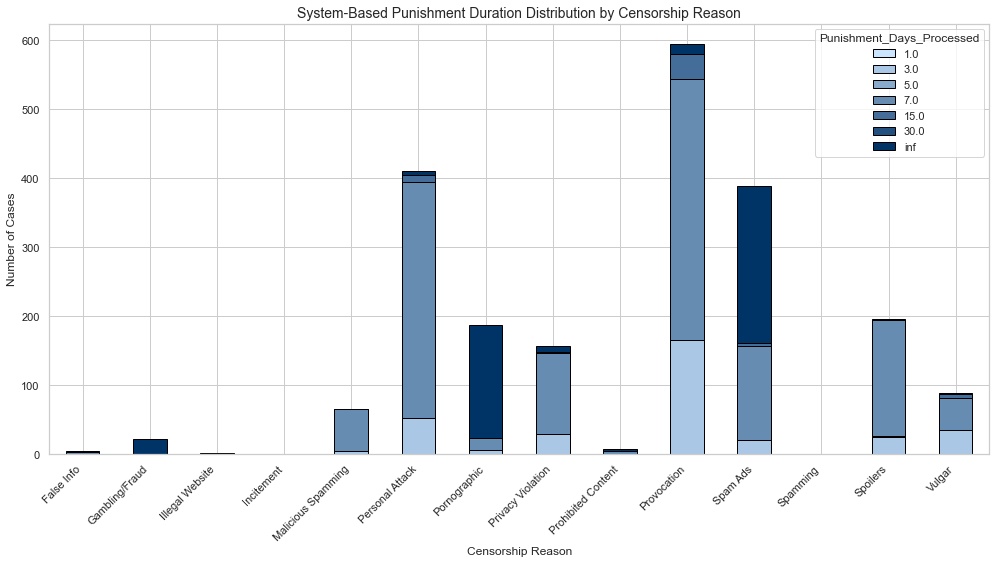

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 替换 -1 为正无穷大（用于排序或可视化的颜色深浅对比）
df_blocked_system['Punishment_Days_Processed'] = df_blocked_system['Punishment_Days'].replace(-1, np.inf)

# 翻译映射表
reason_mapping = {
    1: 'Spamming', 2: 'Floor Snatching', 3: 'Pornographic', 4: 'Gambling/Fraud', 5: 'Prohibited Content',
    6: 'Spam Ads', 7: 'Personal Attack', 8: 'Privacy Violation', 9: 'Provocation', 10: 'Spoilers',
    11: 'Irrelevant Tagging', 12: 'Tag Removal', 13: 'Pornographic', 14: 'Vulgar', 15: 'Violent/Bloody',
    16: 'Malicious Posting', 17: 'Illegal Website', 18: 'False Info', 19: 'Incitement', 20: 'Malicious Spamming',
    21: 'Account Violation', 22: 'Plagiarism', 23: 'Fake Original', 24: 'Inappropriate for Youth',
    25: 'Network Security Threat', 26: 'Misleading Info', 27: 'Fake Official', 28: 'Inappropriate Content',
    29: 'Rule Violation', 30: 'Topic Manipulation', 31: 'Lottery Violation', 32: 'Impersonation'
}

df_blocked_system['Reason_Label'] = df_blocked_system['Censor_Reason'].map(reason_mapping)

# 分组统计
grouped = df_blocked_system.groupby(['Reason_Label', 'Punishment_Days_Processed']).size().unstack(fill_value=0)
grouped = grouped[grouped.columns.sort_values()]  # 排序处罚天数

# 灰度颜色从浅到深
num_shades = grouped.shape[1]
colors = blue_shades(num_shades)

# 绘图
sns.set(style="whitegrid")
grouped.plot(kind='bar', stacked=True, figsize=(14, 8), color=colors, edgecolor='black')

plt.title('System-Based Punishment Duration Distribution by Censorship Reason', fontsize=14)
plt.ylabel('Number of Cases', fontsize=12)
plt.xlabel('Censorship Reason', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("system_punishment_distribution_by_reason_clean.png", dpi=300)
plt.show()


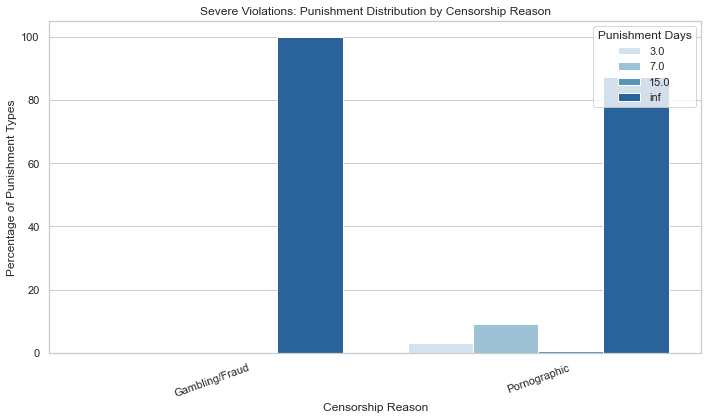

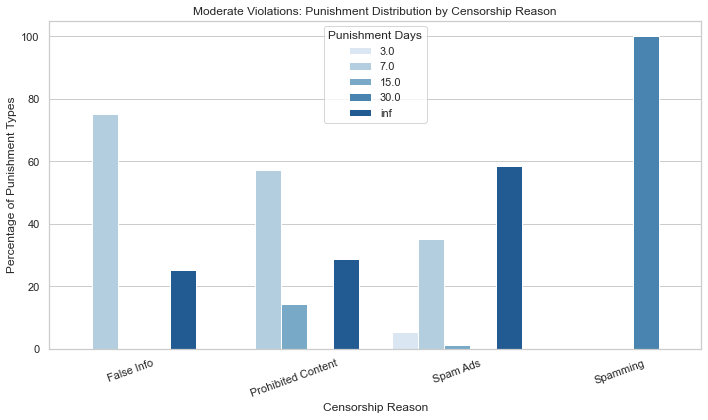

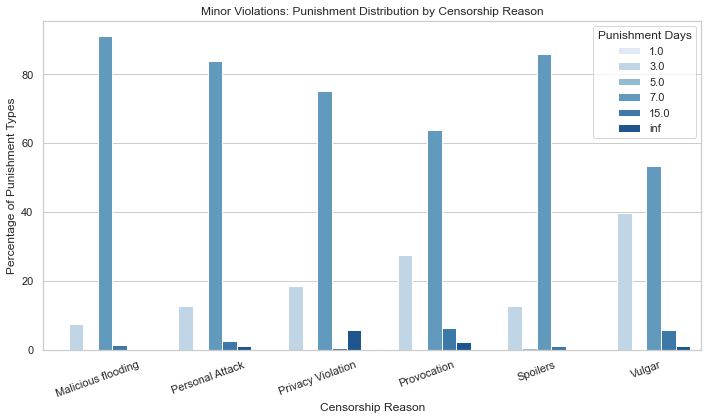

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 定义 censorship reason code 对应英文翻译
reason_code_map = {
    1: 'Spamming',
    2: 'Floor Snatching',
    3: 'Pornographic',
    4: 'Gambling/Fraud',
    5: 'Prohibited Content',
    6: 'Spam Ads',
    7: 'Personal Attack',
    8: 'Privacy Violation',
    9: 'Provocation',
    10: 'Spoilers',
    11: 'Malicious Tagging',
    12: 'Malicious Untagging',
    13: 'Pornographic',
    14: 'Vulgar',
    15: 'Violent Content',
    16: 'Malicious Upload',
    17: 'Illegal Website',
    18: 'False Info',
    19: 'Incitement',
    20: 'Malicious flooding',
    21: 'Account Violation',
    22: 'Plagiarism',
    23: 'Fake Original',
    24: 'Inappropriate for Youth',
    25: 'Network Security Violation',
    26: 'Misleading Info',
    27: 'Fake Official Account',
    28: 'Inappropriate Content',
    29: 'Operational Violation',
    30: 'Malicious Topic Creation',
    31: 'Lottery Violation',
    32: 'Impersonation'
}

# 2. 定义严重程度分组
# Updated severity categorization
severe_reasons = [
    "Gambling/Fraud",
    "Pornographic"
]

moderate_reasons = [
    "Spamming",
    "Spam Ads",
    "False Info",
    "Prohibited Content"
]

minor_reasons = [
    "Malicious flooding",  # 你原意为 malicious spamming / flooding
    "Provocation",
    "Spoilers",
    "Vulgar",
    "Privacy Violation",
    "Personal Attack"
]



# 3. 将 code 转换为英文标签
df_blocked_system['Censorship Reason'] = df_blocked_system['Censor_Reason'].map(reason_code_map)

# 4. 替换 -1 为 inf
df_blocked_system['Punishment_Days_Processed'] = df_blocked_system['Punishment_Days'].replace(-1, float('inf'))

# 5. 绘图函数
def plot_percentage_distribution(df, reasons, severity_label):
    subset = df[df['Censorship Reason'].isin(reasons)].copy()
    
    if subset.empty:
        print(f"No data available for {severity_label} violations.")
        return
    
    grouped = (
        subset
        .groupby(['Censorship Reason', 'Punishment_Days_Processed'])
        .size()
        .reset_index(name='Count')
    )
    grouped['Percentage'] = grouped.groupby('Censorship Reason')['Count'].transform(lambda x: x / x.sum() * 100)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=grouped,
        x='Censorship Reason',
        y='Percentage',
        hue='Punishment_Days_Processed',
        palette='Blues'
    )
    plt.title(f'{severity_label} Violations: Punishment Distribution by Censorship Reason')
    plt.ylabel('Percentage of Punishment Types')
    plt.xlabel('Censorship Reason')
    plt.legend(title='Punishment Days')
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig(f'{severity_label.lower()}_punishment_distribution.png')
    plt.show()

# 6. 调用函数生成图
plot_percentage_distribution(df_blocked_system, severe_reasons, 'Severe')
plot_percentage_distribution(df_blocked_system, moderate_reasons, 'Moderate')
plot_percentage_distribution(df_blocked_system, minor_reasons, 'Minor')


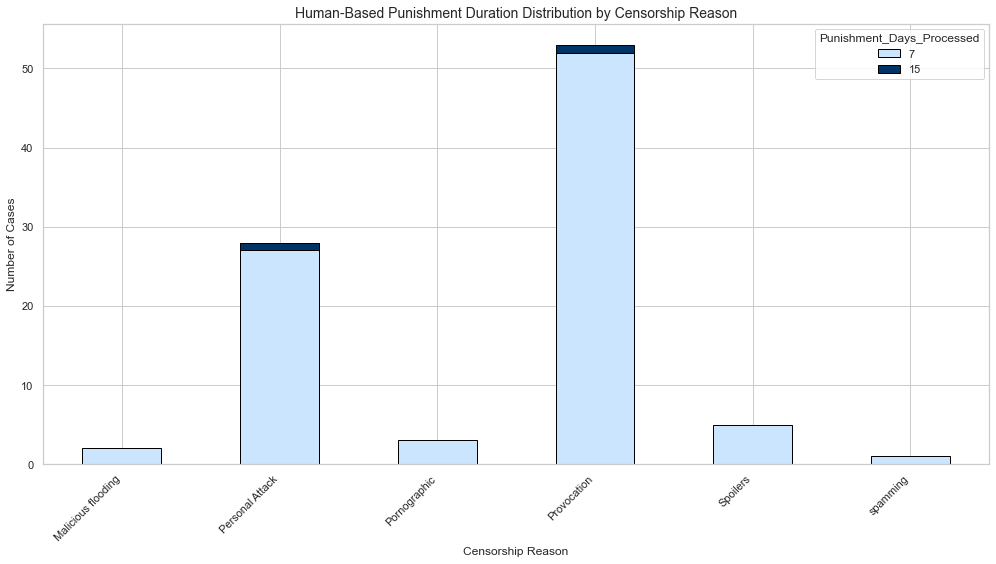

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 替换 -1 为正无穷大（用于排序或可视化的颜色深浅对比）
df_blocked_human['Punishment_Days_Processed'] = df_blocked_human['Punishment_Days'].replace(-1, np.inf)

# 翻译映射表
reason_mapping = {
    1: 'spamming', 2: 'Floor Snatching', 3: 'Pornographic', 4: 'Gambling/Fraud', 5: 'Prohibited Content',
    6: 'Spam Ads', 7: 'Personal Attack', 8: 'Privacy Violation', 9: 'Provocation', 10: 'Spoilers',
    11: 'Irrelevant Tagging', 12: 'Tag Removal', 13: 'Pornographic', 14: 'Vulgar', 15: 'Violent/Bloody',
    16: 'Malicious Posting', 17: 'Illegal Website', 18: 'False Info', 19: 'Incitement', 20: 'Malicious flooding',
    21: 'Account Violation', 22: 'Plagiarism', 23: 'Fake Original', 24: 'Inappropriate for Youth',
    25: 'Network Security Threat', 26: 'Misleading Info', 27: 'Fake Official', 28: 'Inappropriate Content',
    29: 'Rule Violation', 30: 'Topic Manipulation', 31: 'Lottery Violation', 32: 'Impersonation'
}

df_blocked_human['Reason_Label'] = df_blocked_human['Censor_Reason'].map(reason_mapping)

# 分组统计
grouped = df_blocked_human.groupby(['Reason_Label', 'Punishment_Days_Processed']).size().unstack(fill_value=0)
grouped = grouped[grouped.columns.sort_values()]  # 排序处罚天数

# 灰度颜色从浅到深
num_shades = grouped.shape[1]
colors = blue_shades(num_shades)

# 绘图
sns.set(style="whitegrid")
grouped.plot(kind='bar', stacked=True, figsize=(14, 8), color=colors, edgecolor='black')

plt.title('Human-Based Punishment Duration Distribution by Censorship Reason', fontsize=14)
plt.ylabel('Number of Cases', fontsize=12)
plt.xlabel('Censorship Reason', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("human_punishment_distribution_by_reason_clean.png", dpi=300)
plt.show()


,View,Comment_num,Date,Name,Fans,Comment_details
Certification,,,,,,
4,4806000,0,"(2019, 12, 6)",浙江共青团,1543515,[]
5,384000,0,"(2021, 4, 2)",央视网,4775165,[]
4,3628000,68000,"(2019, 3, 19)",浙江共青团,1543515,"[[这还都算轻的 很多人因此丧生了 不乏孕妇和老人, 10, [290.62500, 5..."
4,1539000,40000,"(2019, 3, 20)",共青团中央,11416573,"[[绝对不止这些伤亡, 10, [315.90200, 1, 25, 16777215, 1..."
5,927000,10000,"(2020, 6, 19)",央视新闻,20926873,[]
...,...,...,...,...,...,...
0,91000,59,"(2024, 12, 10)",伊莎电影,1239,"[[和人讲道理前提是对面听得懂人话，听不懂那么最原始的方法最有效, 10, [24.1740..."
0,6533,56,"(2025, 3, 22)",鹿可英国,55238,"[[后面的小哥哈哈哈, 10, [490.02200, 1, 25, 16777215, 1..."
2,598000,813,"(2022, 12, 20)",环球地图,202001,"[[明：都看我干啥, 10, [0.53800, 5, 25, 16646914, 1671..."


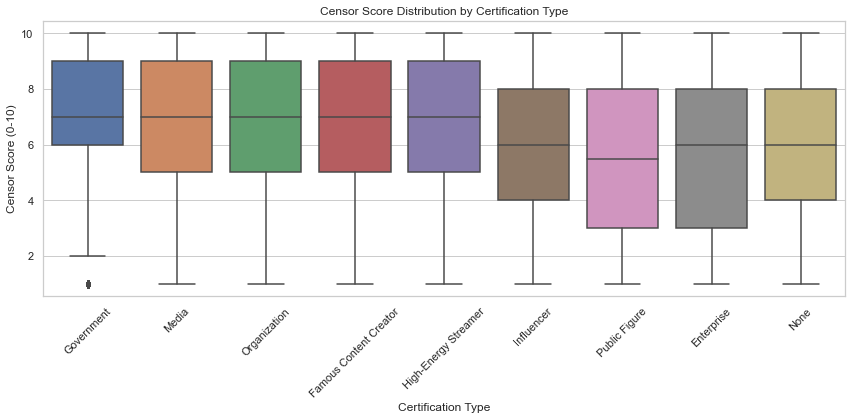

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#df_JB.reset_index(inplace=True)
#df_HK.reset_index(inplace=True)
#df_XJ.reset_index(inplace=True)


df_combined = pd.concat([df_HK, df_XJ, df_JB], ignore_index=True)
cert_mapping = {
    0: "None",
    1: "Famous Content Creator",
    2: "Influencer",
    3: "Enterprise",
    4: "Government",
    5: "Media",
    6: "Organization",
    7: "High-Energy Streamer",
    8: "Unknown",
    9: "Public Figure"
}
cert_order = [
    "Government",
    "Media",
    "Organization",
    "Famous Content Creator",
    "High-Energy Streamer",
    "Influencer",
    "Public Figure",
    "Enterprise",
    "None"
]

# 展开 Comment_details，提取 censor score 并保留 Certification 信息
expanded_data = []
df_combined['Certification_Type'] = df_combined['Certification'].map(cert_mapping)

for _, row in df_combined.iterrows():
    cert_type = row['Certification_Type']
    for comment in row['Comment_details']:
        try:
            score = int(comment[1])
            expanded_data.append({'Certification_Type': cert_type, 'Censor_Score': score})
        except:
            continue  # 跳过格式异常的记录

df_scores = pd.DataFrame(expanded_data)

# 绘图：认证类型的审查分数分布
plt.figure(figsize=(12, 6))
sns.boxplot(x='Certification_Type', y='Censor_Score', data=df_scores, order=cert_order)
plt.title('Censor Score Distribution by Certification Type')
plt.xlabel('Certification Type')
plt.ylabel('Censor Score (0-10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('censor_score_by_certification.png')
plt.show()


In [162]:
df_XJ

,Certification,View,Comment_num,Date,Name,Fans,Comment_details
0,4,4806000,0,"(2019, 12, 6)",浙江共青团,1543515,[]
1,5,384000,0,"(2021, 4, 2)",央视网,4775165,[]
2,4,3628000,68000,"(2019, 3, 19)",浙江共青团,1543515,"[[这还都算轻的 很多人因此丧生了 不乏孕妇和老人, 10, [290.62500, 5..."
3,4,1539000,40000,"(2019, 3, 20)",共青团中央,11416573,"[[绝对不止这些伤亡, 10, [315.90200, 1, 25, 16777215, 1..."
4,5,927000,10000,"(2020, 6, 19)",央视新闻,20926873,[]
...,...,...,...,...,...,...,...
175,0,91000,59,"(2024, 12, 10)",伊莎电影,1239,"[[和人讲道理前提是对面听得懂人话，听不懂那么最原始的方法最有效, 10, [24.1740..."
176,0,6533,56,"(2025, 3, 22)",鹿可英国,55238,"[[后面的小哥哈哈哈, 10, [490.02200, 1, 25, 16777215, 1..."
177,2,598000,813,"(2022, 12, 20)",环球地图,202001,"[[明：都看我干啥, 10, [0.53800, 5, 25, 16646914, 1671..."
178,0,381000,664,"(2023, 3, 13)",子牙观世界--中国龙--,5356,"[[所以重刑犯不能心慈手软, 10, [135.67900, 1, 25, 16777215..."


In [184]:
import pandas as pd

# 收集所有的 censor scores 和对应的认证类型
rows = []

for _, row in df_combined.iterrows():
    cert_type = row['Certification_Type']
    comment_list = row['Comment_details']

    for comment in comment_list:
        try:
            score = int(comment[1])
            rows.append({'Censor_Score': score, 'Certification_Type': cert_type})
        except:
            continue  # 忽略格式不对的弹幕

# 创建新的 DataFrame，适合做统计分析
df_censor_score = pd.DataFrame(rows)

# 检查前几行
print(df_censor_score.head())


   Censor_Score Certification_Type
0            10         Government
1            10         Government
2            10         Government
3            10         Government
4            10         Government


In [185]:
df_censor_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319263 entries, 0 to 319262
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Censor_Score        319263 non-null  int64 
 1   Certification_Type  319263 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.9+ MB


In [186]:
# 计算 summary statistics
summary_stats = df_censor_score.groupby("Certification_Type")["Censor_Score"].agg(
    ['mean', 'var', 'count']
).reset_index()

print(summary_stats)


       Certification_Type      mean       var  count
0              Enterprise  5.578947  8.390977     57
1  Famous Content Creator  6.537152  6.354257  64734
2              Government  7.111339  4.518307  76002
3    High-Energy Streamer  6.816438  5.643370   1825
4              Influencer  6.173508  7.325576  33157
5                   Media  6.788831  5.507234  52271
6                    None  6.209850  7.054769  88811
7            Organization  6.961165  5.149675   1648
8           Public Figure  5.510554  8.266071    758


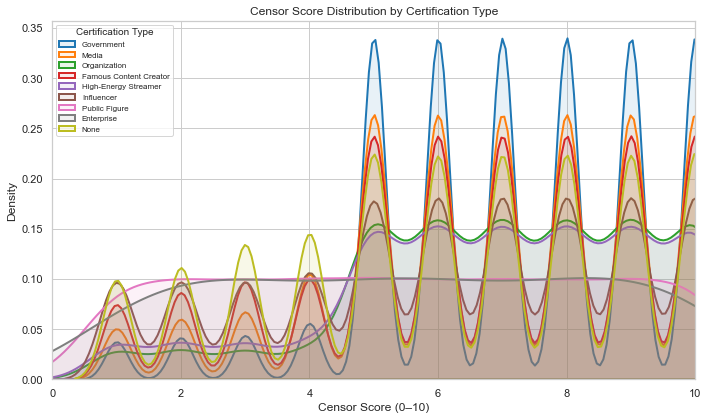

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# 设置调色板
palette = sns.color_palette("tab10", n_colors=len(cert_order))

# 绘制 KDE 曲线
for idx, cert_type in enumerate(cert_order):
    subset = df_censor_score[df_censor_score['Certification_Type'] == cert_type]
    sns.kdeplot(
        data=subset,
        x="Censor_Score",
        bw_adjust=0.8,        # 平滑度调节（越小越平滑）
        fill=True,
        label=cert_type,
        alpha=0.1,            # 填充透明度
        linewidth=2,
        color=palette[idx]
    )

plt.title("Censor Score Distribution by Certification Type")
plt.xlabel("Censor Score (0–10)")
plt.ylabel("Density")
plt.xlim(0, 10)
plt.legend(title="Certification Type", fontsize=8, title_fontsize=10, loc='upper left')
plt.tight_layout()

# 保存图像
plt.savefig("censor_score_kde_certtype.png", dpi=300)
plt.show()


In [188]:
from scipy.stats import f_oneway

# 获取每一类认证对应的 score 列表
groups = [
    group["Censor_Score"].values
    for _, group in df_censor_score.groupby("Certification_Type")
]

# 执行 ANOVA
f_stat, p_value = f_oneway(*groups)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")


F-statistic: 880.5214
P-value: 0.0000e+00


In [189]:
has_negative = df_censor_score[df_censor_score["Censor_Score"] < 0]

# 输出数量和预览几条
print(f"Number of negative scores: {len(has_negative)}")
print(has_negative.head())

Number of negative scores: 0
Empty DataFrame
Columns: [Censor_Score, Certification_Type]
Index: []


In [207]:
from transformers import pipeline
import jieba
import pandas as pd

# 示例弹幕数据
comments = [
    "这个政府太让人失望了",
    "真的很棒，加油！",
    "一般般，没有太多感觉",
    "可恶，太气人了",
    "支持中国的发展",
    "枪毙",
    "脏话",
    "畜生"
]

# Step 1: 中文分词 + 停用词去除
stopwords = set(['的', '了', '和', '是', '我', '在', '不', '就', '人', '都', '一个', '也', '很', '你', '这'])

def preprocess(text):
    tokens = jieba.lcut(text)
    filtered = [t for t in tokens if t not in stopwords and t.strip()]
    return ' '.join(filtered)

processed_comments = [preprocess(c) for c in comments]

# Step 2: 情感分析模型（你可以换成适合自己语料的模型）
sentiment_model = pipeline("sentiment-analysis", model="uer/roberta-base-finetuned-dianping-chinese")

sentiment_results = sentiment_model(processed_comments)

# Step 3: 激进程度打分：这里我们简单基于置信度 or 关键词强度给 1–5 分
def estimate_radicalness(result):
    label = result['label']
    score = result['score']
    
    if label == 'negative':
        if score > 0.75:
            return 5
        elif score > 0.5:
            return 4
        elif score > 0.25:
            return 3
        else:
            return 2
    elif label == 'positive':
        if score > 0.75:
            return 1
        elif score > 0.5:
            return 2
        else:
            return 3
    else:  # neutral or unknown
        return 3

radical_scores = [estimate_radicalness(r) for r in sentiment_results]
sentiment_labels = [r['label'] for r in sentiment_results]

# Step 4: 打印输出
df = pd.DataFrame({
    "Original Comment": comments,
    "Cleaned": processed_comments,
    "Sentiment": sentiment_labels,
    "Radicalness Score (1–5)": radical_scores
})

print(df)


  Original Comment          Cleaned                    Sentiment  \
0       这个政府太让人失望了     这个 政府 太 让 失望  negative (stars 1, 2 and 3)   
1         真的很棒，加油！     真的 很棒 ， 加油 ！     positive (stars 4 and 5)   
2       一般般，没有太多感觉  一般般 ， 没有 太 多 感觉  negative (stars 1, 2 and 3)   
3          可恶，太气人了          可恶 ， 太气  negative (stars 1, 2 and 3)   
4          支持中国的发展         支持 中国 发展     positive (stars 4 and 5)   
5               枪毙               枪毙  negative (stars 1, 2 and 3)   
6               脏话               脏话  negative (stars 1, 2 and 3)   
7               畜生               畜生  negative (stars 1, 2 and 3)   

   Radicalness Score (1–5)  
0                        3  
1                        3  
2                        3  
3                        3  
4                        3  
5                        3  
6                        3  
7                        3  


In [221]:
import sentencepiece
print(sentencepiece.__version__)

0.2.0
